In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit  # シグモイド関数
import japanize_matplotlib
from mpl_toolkits.mplot3d import Axes3D

# CATE推定

In [10]:
# --- 1. 乱数シードの設定 ---
np.random.seed(42)

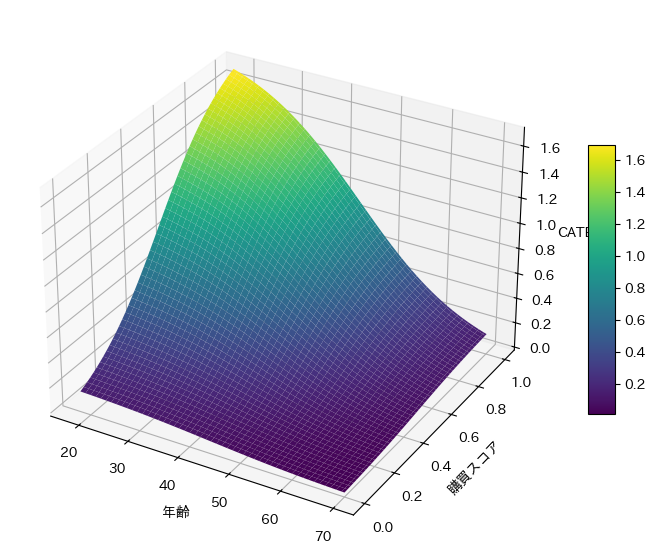

In [ ]:
# --- 2. パラメータと共変量の生成 ---
n = 2000  # データ数
age = np.random.randint(18, 71, size=n)  # 年齢：18〜70歳
purchase_score = np.random.uniform(0, 1, size=n)  # 購買スコア：0〜1

# --- 3. 処置の割当：年齢とスコアに依存（ロジスティック関数） ---
logit_propensity = -1.5 + 0.02 * (70 - age) + 2.0 * purchase_score
propensity = 1 / (1 + np.exp(-logit_propensity))  # ロジスティック関数
treatment = np.random.binomial(1, propensity)

# --- 4. 真のCATE（若い人・スコアが高い人に効く構造） ---
age_scaled = (age - 18) / (70 - 18)  # 若いほど値が小さい
score_scaled = purchase_score

# 高スコア × 若年層の相互作用による処置効果
true_cate = 2.0 * expit(5 * (score_scaled - 0.5)) * expit(5 * (0.5 - age_scaled))

# --- 5. 潜在アウトカムの生成 ---
baseline = 3 + 0.05 * (70 - age) + 2 * purchase_score
y0 = baseline + np.random.normal(0, 1, size=n)
y1 = y0 + true_cate
outcome = treatment * y1 + (1 - treatment) * y0

# --- 6. データフレームの構築 ---
df = pd.DataFrame({
    "age": age,
    "purchase_score": purchase_score,
    "treatment": treatment,
    "outcome": outcome,
    "true_cate": true_cate,
    "propensity": propensity
})

# --- 7. データ可視化：真のCATEの分布 ---

# グリッドを作成
age_grid = np.linspace(18, 70, 100)
score_grid = np.linspace(0, 1, 100)
age_mesh, score_mesh = np.meshgrid(age_grid, score_grid)

# 年齢スケーリング
age_scaled = (age_mesh - 18) / (70 - 18)

# CATE関数
cate_values = 2.0 * expit(5 * (score_mesh - 0.5)) * expit(5 * (0.5 - age_scaled))

# 3Dプロット
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(age_mesh, score_mesh, cate_values, cmap='viridis', edgecolor='none')

#ax.set_title("真のCATEのグラフ")
ax.set_xlabel("年齢")
ax.set_ylabel("購買スコア")
ax.set_zlabel("CATE")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.show();

## 線形関数によるCATE推定

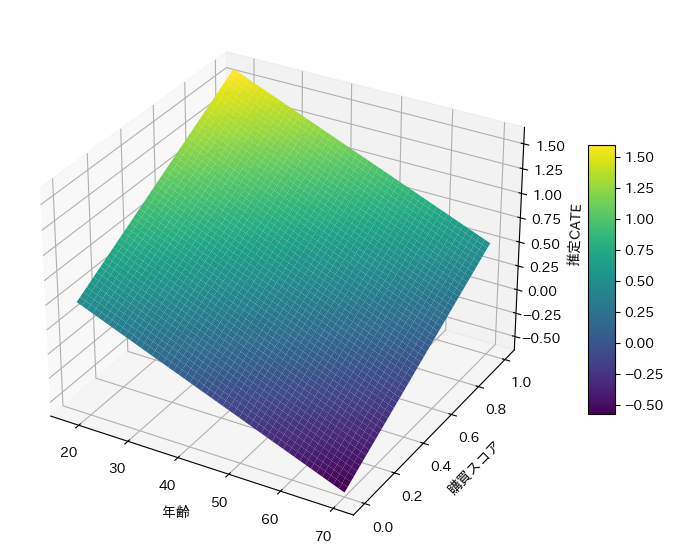

年齢30・スコア0.5の顧客に対する推定CATE（交互作用あり）: 0.804


In [3]:
from sklearn.linear_model import LinearRegression

# 元の特徴量
age_array = np.array(age)
score_array = np.array(purchase_score)
treat_array = np.array(treatment)

# 交互作用項を追加
X = np.column_stack([
    age_array,
    score_array,
    treat_array,
    age_array * treat_array,
    score_array * treat_array
])
y = outcome

# 線形回帰モデルで学習
lr = LinearRegression()
lr.fit(X, y)

# CATE予測用グリッド
age_grid = np.linspace(18, 70, 50)
score_grid = np.linspace(0, 1, 50)
age_mesh, score_mesh = np.meshgrid(age_grid, score_grid)
flat_age = age_mesh.ravel()
flat_score = score_mesh.ravel()

# 処置あり（1）と処置なし（0）の入力データ
X0 = np.column_stack([
    flat_age,
    flat_score,
    np.zeros_like(flat_age),
    flat_age * 0,
    flat_score * 0
])
X1 = np.column_stack([
    flat_age,
    flat_score,
    np.ones_like(flat_age),
    flat_age * 1,
    flat_score * 1
])

# CATE推定
y0_pred = lr.predict(X0)
y1_pred = lr.predict(X1)
cate_pred = (y1_pred - y0_pred).reshape(age_mesh.shape)

# 3D描画
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(age_mesh, score_mesh, cate_pred, cmap='viridis', edgecolor='none')
#ax.set_title("S-Learner + 線形回帰（交互作用あり）による CATE 推定")
ax.set_xlabel("年齢")
ax.set_ylabel("購買スコア")
ax.set_zlabel("推定CATE")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()

# 年齢30・スコア0.5のCATE
x0_test = np.array([[30, 0.5, 0, 0 * 30, 0 * 0.5]])
x1_test = np.array([[30, 0.5, 1, 1 * 30, 1 * 0.5]])
cate_est = lr.predict(x1_test)[0] - lr.predict(x0_test)[0]

print(f"年齢30・スコア0.5の顧客に対する推定CATE（交互作用あり）: {cate_est:.3f}")

## CATEの事後分布推定

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.
/var/folders/0x/_j0np00125943j5y58cl1p9r0000gn/T/ipykernel_14306/1700516678.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


CATE 事後平均: 0.803
CATE 95%信用区間: [0.675, 0.929]


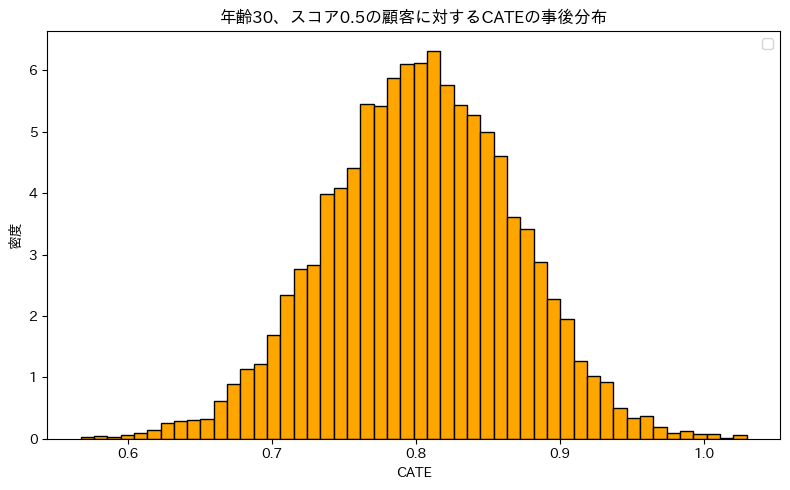

In [4]:
import pymc as pm

# ---------- データ準備 ----------
age_array = np.array(age)
score_array = np.array(purchase_score)
treat_array = np.array(treatment)
outcome_array = np.array(outcome)

# 特徴量：定数項 + 説明変数 + 交互作用
X = np.column_stack([
    np.ones_like(age_array),         # 定数項
    age_array,
    score_array,
    treat_array,
    age_array * treat_array,
    score_array * treat_array
])  # shape (n_samples, 6)

# ---------- PyMC モデル構築 ----------
with pm.Model() as model:
    # 回帰係数の事前分布：N(0, 10^2) × 6
    beta = pm.Normal("beta", mu=0, sigma=10, shape=6)
    
    # 誤差の分散の事前分布：Inverse Gamma
    sigma2 = pm.InverseGamma("sigma2", alpha=2, beta=1)
    sigma = pm.Deterministic("sigma", pm.math.sqrt(sigma2))

    # 線形予測
    mu = pm.math.dot(X, beta)

    # 観測モデル
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=outcome_array)

    # MCMC サンプリング
    trace = pm.sample(2000, tune=1000, target_accept=0.95, random_seed=42, return_inferencedata=True)

# ---------- CATEの事後分布 ----------
beta_samples = trace.posterior["beta"].stack(draws=("chain", "draw")).values.T  # shape (n_samples, 6)

# 年齢30・スコア0.5 に対する CATE = β3 + 30×β4 + 0.5×β5
cate_samples = (
    beta_samples[:, 3] +            # β_treatment
    beta_samples[:, 4] * 30 +       # β_treatment×age × 30
    beta_samples[:, 5] * 0.5        # β_treatment×score × 0.5
)

# ---------- 出力と可視化 ----------
print(f"CATE 事後平均: {np.mean(cate_samples):.3f}")
print(f"CATE 95%信用区間: [{np.percentile(cate_samples, 2.5):.3f}, {np.percentile(cate_samples, 97.5):.3f}]")

plt.figure(figsize=(8, 5))
plt.hist(cate_samples, bins=50, density=True, color="orange", edgecolor="k")
plt.title("年齢30、スコア0.5の顧客に対するCATEの事後分布")
plt.xlabel("CATE")
plt.ylabel("密度")
plt.legend()
plt.tight_layout()
plt.show();


## S-LearnerによるCATE推定

Fitting 5 folds for each of 27 candidates, totalling 135 fits


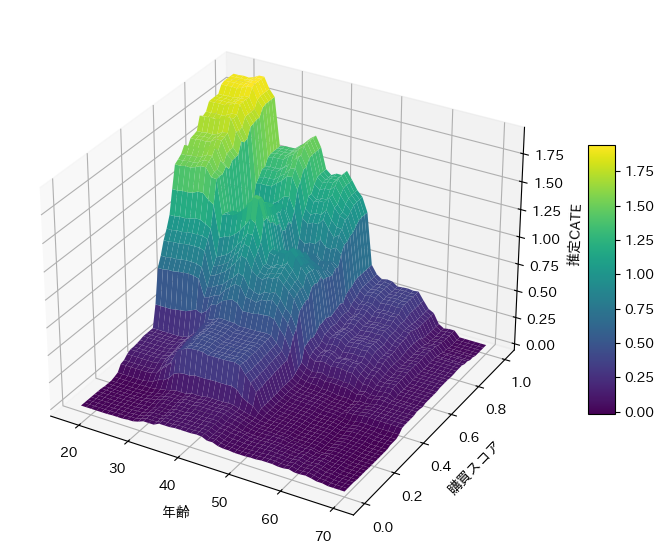

年齢30・スコア0.5の顧客に対する推定CATE: 0.571


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# 特徴量とアウトカム
X = np.column_stack([age, purchase_score, treatment])
y = outcome

# ハイパーパラメータグリッド
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, None],
    "min_samples_leaf": [1, 5, 10]
}

# モデルとグリッドサーチ
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    rf, param_grid, cv=5, scoring="neg_mean_squared_error",
    n_jobs=-1, verbose=1
)
grid_search.fit(X, y)
best_rf = grid_search.best_estimator_

# CATE予測用グリッド
age_grid = np.linspace(18, 70, 50)
score_grid = np.linspace(0, 1, 50)
age_mesh, score_mesh = np.meshgrid(age_grid, score_grid)
X0 = np.column_stack([age_mesh.ravel(), score_mesh.ravel(), np.zeros(age_mesh.size)])
X1 = np.column_stack([age_mesh.ravel(), score_mesh.ravel(), np.ones(age_mesh.size)])

# CATE推定
y0_pred = best_rf.predict(X0)
y1_pred = best_rf.predict(X1)
cate_pred = (y1_pred - y0_pred).reshape(age_mesh.shape)

# 3D描画
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(age_mesh, score_mesh, cate_pred, cmap='viridis', edgecolor='none')
#ax.set_title("S-Learner + Random Forest による CATE 推定")
ax.set_xlabel("年齢")
ax.set_ylabel("購買スコア")
ax.set_zlabel("推定CATE")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()

# 年齢30・スコア0.5のCATE
x0_test = np.array([[30, 0.5, 0]])
x1_test = np.array([[30, 0.5, 1]])
cate_est = best_rf.predict(x1_test)[0] - best_rf.predict(x0_test)[0]

print(f"年齢30・スコア0.5の顧客に対する推定CATE: {cate_est:.3f}")


## T-LearnerによるCATE推定

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


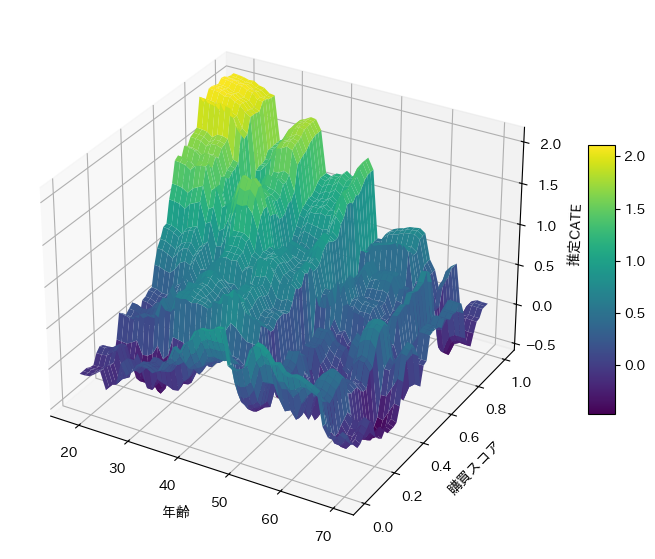

年齢30・スコア0.5のCATE推定値: 0.542


In [8]:
# ---------- データ準備 ----------
age_array = np.array(age)
score_array = np.array(purchase_score)
treat_array = np.array(treatment)
y_array = np.array(outcome)

# 処置群と対照群に分割
X_control = np.column_stack([age_array[treat_array == 0], score_array[treat_array == 0]])
y_control = y_array[treat_array == 0]

X_treat = np.column_stack([age_array[treat_array == 1], score_array[treat_array == 1]])
y_treat = y_array[treat_array == 1]

# ---------- ハイパーパラメータグリッド ----------
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, None],
    "min_samples_leaf": [1, 5, 10]
}

# ---------- モデル学習（対照群） ----------
rf_control = RandomForestRegressor(random_state=42)
gs_control = GridSearchCV(
    rf_control, param_grid, cv=5,
    scoring="neg_mean_squared_error", n_jobs=-1, verbose=1
)
gs_control.fit(X_control, y_control)
best_control = gs_control.best_estimator_

# ---------- モデル学習（処置群） ----------
rf_treat = RandomForestRegressor(random_state=42)
gs_treat = GridSearchCV(
    rf_treat, param_grid, cv=5,
    scoring="neg_mean_squared_error", n_jobs=-1, verbose=1
)
gs_treat.fit(X_treat, y_treat)
best_treat = gs_treat.best_estimator_

# ---------- CATEのグリッド推定 ----------
age_grid = np.linspace(18, 70, 50)
score_grid = np.linspace(0, 1, 50)
age_mesh, score_mesh = np.meshgrid(age_grid, score_grid)
X_grid = np.column_stack([age_mesh.ravel(), score_mesh.ravel()])

y0_pred = best_control.predict(X_grid)
y1_pred = best_treat.predict(X_grid)
cate_grid = (y1_pred - y0_pred).reshape(age_mesh.shape)

# ---------- 可視化 ----------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(age_mesh, score_mesh, cate_grid, cmap='viridis', edgecolor='none')
#ax.set_title("T-Learner + Random ForestによるCATE推定")
ax.set_xlabel("年齢")
ax.set_ylabel("購買スコア")
ax.set_zlabel("推定CATE")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()

# ---------- 特定ポイントのCATE（例：年齢30、スコア0.5） ----------
x_test = np.array([[30, 0.5]])
cate_est = best_treat.predict(x_test)[0] - best_control.predict(x_test)[0]

print(f"年齢30・スコア0.5のCATE推定値: {cate_est:.3f}")

# CACE推定

In [11]:
# 構造方程式の設定

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def f_X1(sample_size):
    return np.random.binomial(1, 0.5, sample_size)

def f_X2(sample_size):
    return np.random.normal(0, 1, sample_size)

def f_X3(X1, X2, sample_size):
    p = sigmoid(-0.3+0.9*X1-11.2*X2)
    return np.random.binomial(1, p, sample_size)

def f_T(X1, X2, sample_size):
    p = sigmoid(-0.5+1.2*X1+0.8*X2)
    return np.random.binomial(1, p, sample_size)

def f_X4(T, X3, sample_size):
    return 3 + 2.5*T + 3*X3 + np.random.normal(0, np.sqrt(1.5), sample_size)

def f_X5(X4, sample_size):
    return 100 + 10*X4 + np.random.normal(0, np.sqrt(20), sample_size)

def f_Y(X1, X3, X5, sample_size):
    return 1000 + 100*X1 + 500*X3 + 15*X5 + np.random.normal(0, np.sqrt(100), sample_size)

In [12]:
# データの生成

sample_size = 100
X1 = f_X1(sample_size)
X2 = f_X2(sample_size)
X3 = f_X3(X1, X2, sample_size)
T = f_T(X1, X2, sample_size)
X4 = f_X4(T, X3, sample_size)
X5 = f_X5(X4, sample_size)
Y = f_Y(X1, X3, X5, sample_size)

df = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'T': T,
    'X4': X4,
    'X5': X5,
    'Y': Y
})

In [13]:
from sklearn.linear_model import LogisticRegression

# 周辺分布・条件付き分布の推定

# p(x1)の推定
p_x1 = df['X1'].mean()

# p(x2)の推定
mu_x2 = df['X2'].mean()
sigma_x2 = df['X2'].std()

# p(x3|x1,x2)の推定
logisitic_model_x3 = LogisticRegression()
logisitic_model_x3.fit(df[['X1', 'X2']].values, df['X3'].values)

# p(t|x1,x2)の推定
logisitic_model_t = LogisticRegression()
logisitic_model_t.fit(df[['X1', 'X2']].values, df['T'].values)

# p(x4|t,x3)の推定
linear_model_x4 = LinearRegression(fit_intercept=True)
linear_model_x4.fit(df[['T', 'X3']].values, df['X4'].values)
sigma_x4 = np.sqrt(((df['X4'].values - linear_model_x4.predict(df[['T', 'X3']].values)) ** 2).mean())

# p(x5|x4)の推定
linear_model_x5 = LinearRegression(fit_intercept=True)
linear_model_x5.fit(df[['X4']].values, df['X5'].values)
sigma_x5 = np.sqrt(((df['X5'].values - linear_model_x5.predict(df[['X4']].values)) ** 2).mean())

# p(y|x1,x3,x5)の推定
linear_model_y = LinearRegression(fit_intercept=True)
linear_model_y.fit(df[['X1', 'X3', 'X5']].values, df['Y'].values)
sigma_y = np.sqrt(((df['Y'].values - linear_model_y.predict(df[['X1', 'X3', 'X5']].values)) ** 2).mean())

In [14]:
# 推定した分布でのCACEの計算

X1 = np.random.binomial(1, p_x1, 100000)
X2 = np.random.normal(mu_x2, sigma_x2, 100000)
p_X3 = logisitic_model_x3.predict_proba(np.c_[X1, X2])[:, 1]
X3 = np.random.binomial(1, p_X3, 100000)
T = np.zeros(100000)
X4 = np.random.normal(linear_model_x4.predict(np.c_[T, X3]), sigma_x4, 100000)
X5 = np.random.normal(linear_model_x5.predict(np.c_[X4]), sigma_x5, 100000)
Y_0 = linear_model_y.predict(np.c_[X1, X3, X5])

hat_df_0 = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'T': T,
    'X4': X4,
    'X5': X5,
    'Y': Y_0
})

X1 = np.random.binomial(1, p_x1, 100000)
X2 = np.random.normal(mu_x2, sigma_x2, 100000)
p_X3 = logisitic_model_x3.predict_proba(np.c_[X1, X2])[:, 1]
X3 = np.random.binomial(1, p_X3, 100000)
T = np.ones(100000)
X4 = np.random.normal(linear_model_x4.predict(np.c_[T, X3]), sigma_x4, 100000)
X5 = np.random.normal(linear_model_x5.predict(np.c_[X4]), sigma_x5, 100000)
Y_1 = linear_model_y.predict(np.c_[X1, X3, X5])

hat_df_1 = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'T': T,
    'X4': X4,
    'X5': X5,
    'Y': Y_1
})

hat_df_0_X2_pos = hat_df_0[hat_df_0['X2']>0]
hat_df_0_X2_neg = hat_df_0[hat_df_0['X2']<0]
hat_df_1_X2_pos = hat_df_1[hat_df_1['X2']>0]
hat_df_1_X2_neg = hat_df_1[hat_df_1['X2']<0]

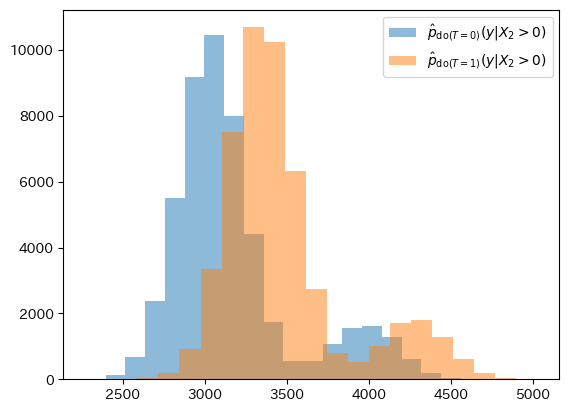

In [15]:
# \hat{p}_{do(T=0)}(y|X4>0)と\hat{p}_{do(T=1)}(y|X4<0)の描画

plt.hist(hat_df_0_X2_pos['Y'], bins=20, alpha=0.5, label=r'$\hat{p}_{\mathrm{do}(T=0)}(y|X_{2}>0)$')
plt.hist(hat_df_1_X2_pos['Y'], bins=20, alpha=0.5, label=r'$\hat{p}_{\mathrm{do}(T=1)}(y|X_{2}>0)$')
plt.legend()
plt.show();

In [16]:
# CACEの推定値

print('CACEの推定値:', hat_df_1_X2_pos['Y'].mean() - hat_df_0_X2_pos['Y'].mean())

CACEの推定値: 307.1261272505949


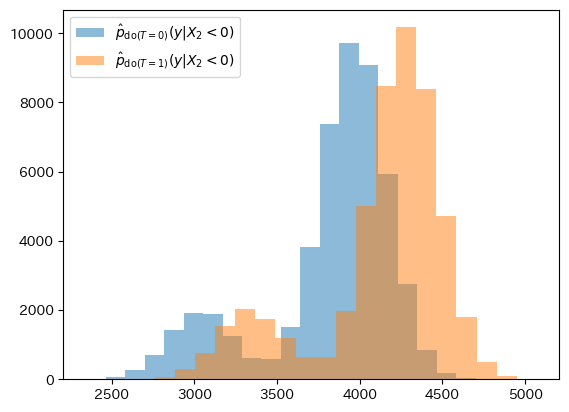

In [17]:
# \hat{p}_{do(T=0)}(y|X1=1)と\hat{p}_{do(T=1)}(y|X1=1)の描画

plt.hist(hat_df_0_X2_neg['Y'], bins=20, alpha=0.5, label=r'$\hat{p}_{\mathrm{do}(T=0)}(y|X_{2}<0)$')
plt.hist(hat_df_1_X2_neg['Y'], bins=20, alpha=0.5, label=r'$\hat{p}_{\mathrm{do}(T=1)}(y|X_{2}<0)$')
plt.legend()
plt.show();

In [18]:
# CACEの推定値

print('CACEの推定値:', hat_df_1_X2_neg['Y'].mean() - hat_df_0_X2_neg['Y'].mean())

CACEの推定値: 305.5500865689878
